In [113]:
import numpy as np
import pandas as pd 
from elo import Bot, Referee, EloRanker,load_jsonl
import matplotlib.pyplot as plt 
from tqdm import tqdm

pd.options.display.float_format = '{:.0f}'.format

In [114]:
tournament = 'tournaments/rakuda_koukou_v0_tournament'
tournament = ''
if not tournament:
    bots = [
        Bot('GPT3', 'answers/rakuda_koukou_v0/gpt3.jsonl'),
        Bot('Rinna 3.6B', 'answers/rakuda_koukou_v0/rinna-gpt-neox-3.6b.jsonl'),
        #Bot('Llama Retoken', 'answers/rakuda_koukou_v0/llama_retoken_alpaca_gpt4.jsonl'),
        Bot('GPT4 Alpaca', 'answers/rakuda_koukou_v0/gpt4alpaca.jsonl'),
        Bot('OpenCalm-Stormy', 'answers/rakuda_koukou_v0/stormy.jsonl')
    ]

    referee = Referee('matchups/rakuda_koukou_v0.jsonl',
                      'prompts/rakuda_reviewer.jsonl',
                      'prompts/rakuda_prompt_threeclass.jsonl',
                      max_tokens=1024,
                      model='gpt-3.5-turbo-0301')

    ranker = EloRanker(bots, 'questions/rakuda_koukou_v0.jsonl', referee, verbose=False)
    ranker.run_tournament(100)

    ranker.output_standings('tournaments/rakuda_koukou_v0_tournament_result.jsonl')    
    ranker.output_tournament('tournaments/rakuda_koukou_v0_tournament.jsonl')
    tournament = 'tournaments/rakuda_koukou_v0_tournament'

## The tournament standings

In [115]:
standings = pd.DataFrame(load_jsonl(tournament+'_result.jsonl'))
standings.head()

,name,elo,num_matches
0,GPT3,1320,52
1,OpenCalm-Stormy,937,49
2,Rinna 3.6B,925,50
3,GPT4 Alpaca,818,49


## The full results

In [116]:
results = pd.DataFrame(load_jsonl(tournament+'.jsonl'))
results.head(1)

,bot1,bot2,prematch_elo1,prematch_elo2,challenge,response1,response2,referee_comments,result,postmatch_elo1,postmatch_elo2
0,GPT3,Rinna 3.6B,1000,1000,日本のエネルギー政策と環境保護のバランスについて、現状と改善策を提案してください。,現在の日本のエネルギー政策は、原子力発電を含めた化石燃料と再生可能エネルギーの両方を導入する...,日本は、エネルギー効率の高い省エネ技術や再生可能エネルギーへの投資により、世界でトップクラス...,アシスタント1の回答は、質問に対して詳細で関連性があり、提案された改善策は具体的で実現可能性...,1,1016,984


## Evolution across the tournament

In [117]:
import matplotlib.pyplot as plt 
elos = {}
for bot in results.bot1.unique():
    bot_elos = [1000]
    for i, result in results.iterrows():
        if result['bot1'] == bot:
            bot_elos.append(result['postmatch_elo1'])
        elif result['bot2'] == bot:
            bot_elos.append(result['postmatch_elo2'])
        else:
            pass
    elos.update({bot:bot_elos})

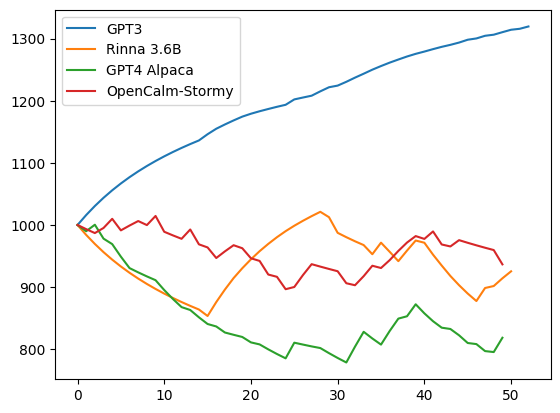

In [118]:
for k,v in elos.items():
    plt.plot(v, label=k)
plt.legend()

## Number of ties

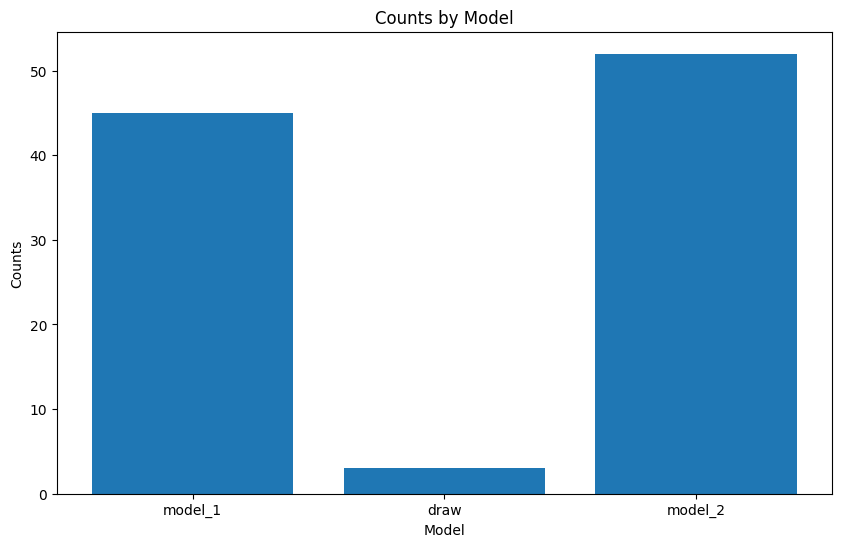

In [120]:
df = results["result"].value_counts()

# Order DataFrame by result
df = df.loc[[1, 3, 2]].reset_index()

# Define labels
labels = ["model_1", "draw", "model_2"]

# Plot
plt.figure(figsize=[10,6])
plt.bar(labels, df["count"])
plt.xlabel('Model')
plt.ylabel('Counts')
plt.title('Counts by Model')
plt.show()

## Head to head results

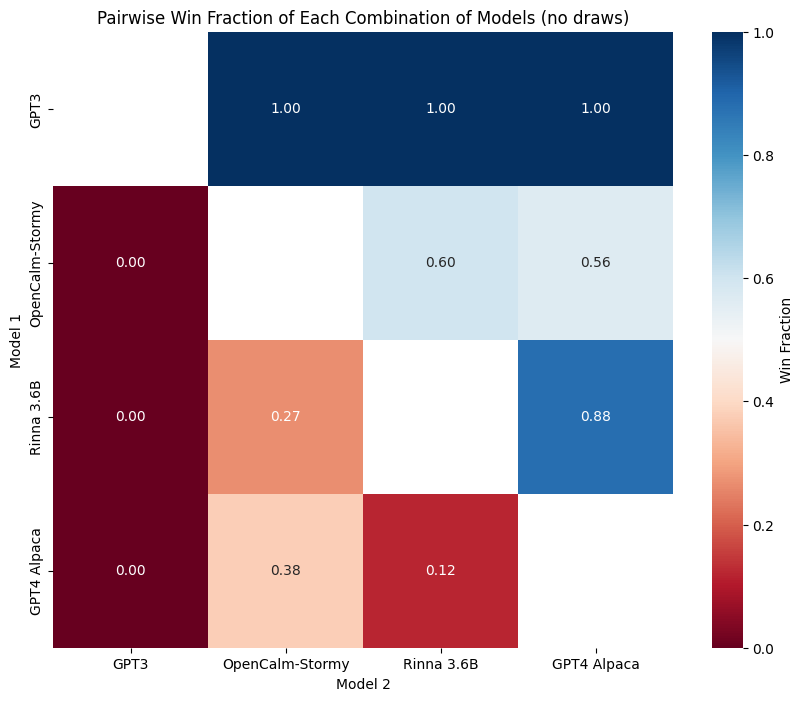

In [121]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def compute_pairwise_win_fraction(battles):
    all_models = list(set(battles["bot1"]).union(battles["bot2"]))
    empty_df = pd.DataFrame(0, index=all_models, columns=all_models)

    
    # Times each model wins as Model A
    a_win_ptbl = pd.pivot_table(
        battles[battles['result'] == 1], 
        index="bot1", columns="bot2", aggfunc="size", fill_value=0)
    
    # Ensure all models appear in the pivot table
    a_win_ptbl = empty_df.add(a_win_ptbl, fill_value=0)

    # Table counting times each model wins as Model B
    b_win_ptbl = pd.pivot_table(
        battles[battles['result'] == 2], 
        index="bot1", columns="bot2", aggfunc="size", fill_value=0)
    
    # Ensure all models appear in the pivot table
    b_win_ptbl = empty_df.add(b_win_ptbl, fill_value=0)

    # Table counting number of A-B pairs
    num_battles_ptbl = pd.pivot_table(battles, 
        index="bot1", columns="bot2", aggfunc="size", fill_value=0)

    # Computing the proportion of wins for each model as A and as B 
    # against all other models
    row_beats_col_freq = (
        (a_win_ptbl + b_win_ptbl.T) / 
        (num_battles_ptbl + num_battles_ptbl.T)
    )

    # Arrange ordering according to proprition of wins
    prop_wins = row_beats_col_freq.mean(axis=1).sort_values(ascending=False)
    model_names = list(prop_wins.keys())
    row_beats_col = row_beats_col_freq.loc[model_names, model_names]
    return row_beats_col

def visualize_pairwise_win_fraction(battles, title):
    row_beats_col = compute_pairwise_win_fraction(battles)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(row_beats_col, annot=True, fmt=".2f", cmap='RdBu', cbar_kws={'label': 'Win Fraction'})
    ax.set_title(title)
    ax.set_xlabel("Model 2")
    ax.set_ylabel("Model 1")

    #plt.savefig("pairwise_win_fraction.png")
    plt.show()

visualize_pairwise_win_fraction(results, title="Pairwise Win Fraction of Each Combination of Models (no draws)")

## Confirm elo computation was performed properly

In [122]:
from collections import defaultdict

def compute_elo(battles, K=32, SCALE=400, BASE=10, INIT_RATING=1000):
    rating = defaultdict(lambda: INIT_RATING)
 
    for rd, model_a, model_b, win in battles[['bot1', 'bot2', 'result']].itertuples():
        ra = rating[model_a]
        rb = rating[model_b]
        ea = 1 / (1 + BASE ** ((rb - ra) / SCALE))
        eb = 1 / (1 + BASE ** ((ra - rb) / SCALE))
        if win == 1:
            sa = 1
        elif win == 2:
            sa = 0
        elif win == 3:
            sa = 0.5
        else:
            raise Exception(f"unexpected vote {win}")
        rating[model_a] += K * (sa - ea)
        rating[model_b] += K * (1 - sa - eb)
    
    rating = dict(sorted(rating.items(), key=lambda item: item[1], reverse=True))
    return rating

In [123]:
assert(all([row['elo'] == compute_elo(results)[row['name']] for i,row in standings.iterrows()]))

In [91]:
standings

,name,elo,num_matches
0,GPT3,1320,52
1,OpenCalm-Stormy,937,49
2,Rinna 3.6B,925,50
3,GPT4 Alpaca,818,49


# Predict win rate

In [124]:
def predict_win_rate(standings, K=32, SCALE=400, BASE=10, INIT_RATING=1000):
    names = sorted(list(standings['name']))
    wins = defaultdict(lambda: defaultdict(lambda: 0))
    for a in names:
        for b in names:
            ea = 1 / (1 + BASE ** ((standings.loc[standings['name'] == b, 'elo'].values[0] - standings.loc[standings['name'] == a, 'elo'].values[0]) / SCALE))
            wins[a][b] = ea
            wins[b][a] = 1 - ea
      
    data = {
        a: [wins[a][b] if a != b else np.NAN for b in names]
        for a in names
    }

    df = pd.DataFrame(data, index=names)
    df.index.name = "model_a"
    df.columns.name = "model_b"
    return df.T

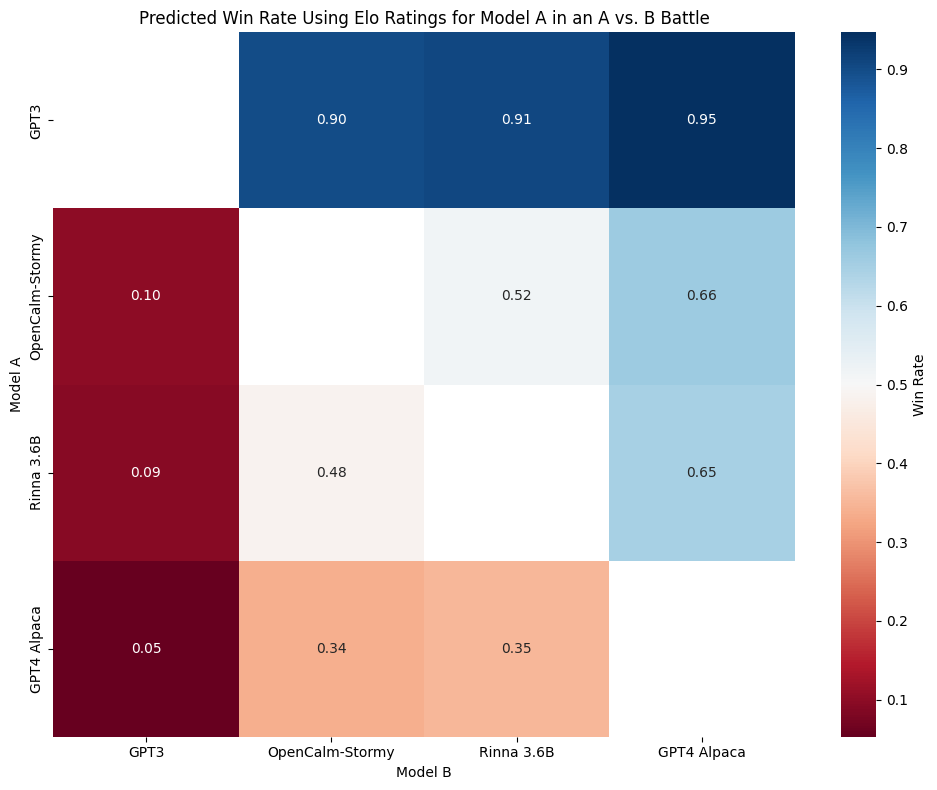

In [125]:
win_rate = predict_win_rate(standings)

ordered_models = win_rate.mean(axis=1).sort_values(ascending=False).index
ordered_win_rate = win_rate.loc[ordered_models, ordered_models]

plt.figure(figsize=(10, 8))
ax = sns.heatmap(ordered_win_rate, annot=True, fmt=".2f", cmap='RdBu', cbar_kws={'label': 'Win Rate'})
plt.title('Predicted Win Rate Using Elo Ratings for Model A in an A vs. B Battle')
plt.xlabel('Model B')
plt.ylabel('Model A')
plt.tight_layout()
# plt.savefig('elo_predicted_win_rate.png')
plt.show()

### Compute Bootstrap Confidence Intervals for Elo Scores

The previous linear update method may be sensitive to battle orders. Here we use bootstrap to estimate the confidence intervals

In [126]:
def get_bootstrap_result(battles, func_compute_elo, num_round):
    rows = []
    for i in tqdm(range(num_round), desc="bootstrap"):
        rows.append(func_compute_elo(battles.sample(frac=1.0, replace=True)))
    df = pd.DataFrame(rows)
    return df[df.median().sort_values(ascending=False).index]

BOOTSTRAP_ROUNDS = 10000

bootstrap_elo_lu = get_bootstrap_result(results, compute_elo, BOOTSTRAP_ROUNDS)
bootstrap_lu_median = bootstrap_elo_lu.median().reset_index().set_axis(["model", "rating"], axis=1)
bootstrap_lu_median

bootstrap: 100%|██████████| 10000/10000 [00:10<00:00, 923.03it/s]


,model,rating
0,GPT3,1325
1,OpenCalm-Stormy,940
2,Rinna 3.6B,939
3,GPT4 Alpaca,796


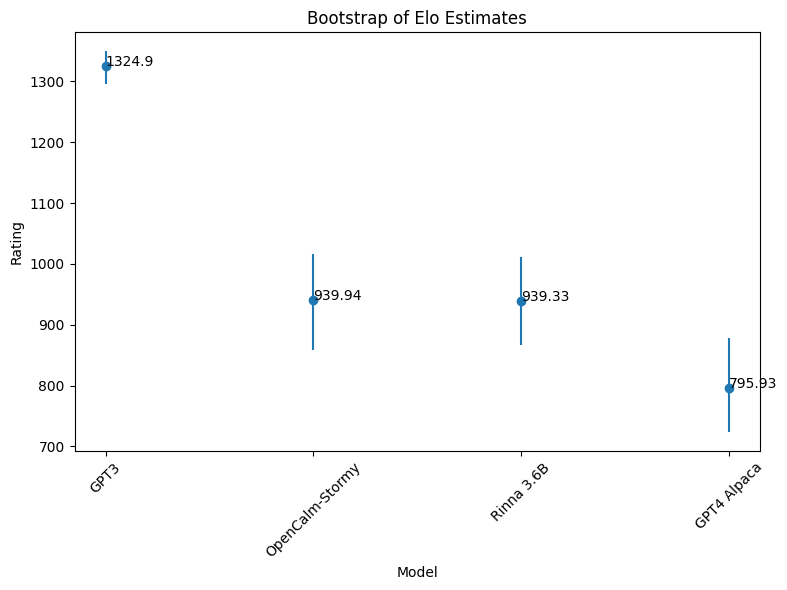

<Figure size 640x480 with 0 Axes>

In [127]:
def visualize_bootstrap_scores(df, title):
    bars = pd.DataFrame(dict(
        lower = df.quantile(.025),
        rating = df.quantile(.5),
        upper = df.quantile(.975))).reset_index().rename(columns={"index": "model"}).sort_values("rating", ascending=False)
    bars['error_y'] = bars['upper'] - bars["rating"]
    bars['error_y_minus'] = bars['rating'] - bars["lower"]
    bars['rating_rounded'] = np.round(bars['rating'], 2)
    
    plt.figure(figsize=(8, 6))
    plt.errorbar(bars['model'], bars['rating'], yerr=[bars['error_y_minus'], bars['error_y']], fmt='o')
    for i, txt in enumerate(bars['rating_rounded']):
        plt.annotate(txt, (bars['model'][i], bars['rating'][i]))
    plt.title(title)
    plt.xlabel('Model')
    plt.ylabel('Rating')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    #plt.savefig('bootstrap_elo_estimates.png')


visualize_bootstrap_scores(bootstrap_elo_lu, "Bootstrap of Elo Estimates")

# plotly version
# def visualize_bootstrap_scores(df, title):
#     bars = pd.DataFrame(dict(
#         lower = df.quantile(.025),
#         rating = df.quantile(.5),
#         upper = df.quantile(.975))).reset_index(names="model").sort_values("rating", ascending=False)
#     bars['error_y'] = bars['upper'] - bars["rating"]
#     bars['error_y_minus'] = bars['rating'] - bars["lower"]
#     bars['rating_rounded'] = np.round(bars['rating'], 2)
#     fig = px.scatter(bars, x="model", y="rating", error_y="error_y", 
#                       error_y_minus="error_y_minus", text="rating_rounded", 
#                       title=title)
#     fig.update_layout(xaxis_title="Model", yaxis_title="Rating")
#     return fig

# fig = visualize_bootstrap_scores(bootstrap_elo_lu, "Bootstrap of Elo Estimates")
# fig.write_html("bootstrap_elo_estimates.html", full_html=False, include_plotlyjs="cdn")
# fig


### Compare bootstrap error estimate to time evolution

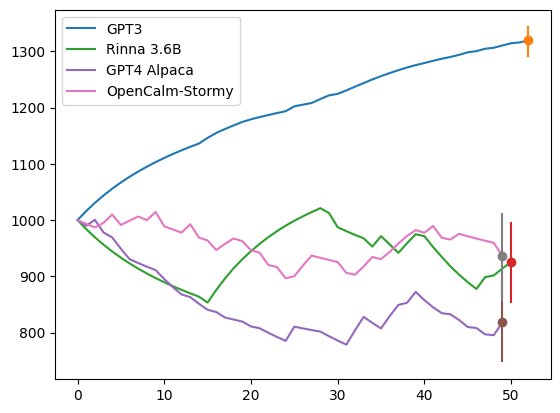

In [136]:
import matplotlib.pyplot as plt 

elos = {}
for bot in results.bot1.unique():
    bot_elos = [1000]
    for i, result in results.iterrows():
        if result['bot1'] == bot:
            bot_elos.append(result['postmatch_elo1'])
        elif result['bot2'] == bot:
            bot_elos.append(result['postmatch_elo2'])
        else:
            pass
    elos.update({bot:bot_elos})
        
df = bootstrap_elo_lu
bars = pd.DataFrame(dict(
        lower = df.quantile(.025),
        rating = df.quantile(.5),
        upper = df.quantile(.975))).reset_index().rename(columns={"index": "model"}).sort_values("rating", ascending=False)
bars['error_y'] = bars['upper'] - bars["rating"]
bars['error_y_minus'] = bars['rating'] - bars["lower"]
bars['rating_rounded'] = np.round(bars['rating'], 2)
bars = bars.set_index('model')

for k,v in elos.items():
    plt.plot(v, label=k)
    if k in bars.index:  # check if the model has bootstrap estimates
        plt.errorbar(len(v) - 1, v[-1], 
                     yerr=[[bars.loc[k, 'error_y_minus']], 
                           [bars.loc[k, 'error_y']]],
                     fmt='o')
    
plt.legend()

In [134]:
k

'OpenCalm-Stormy'

In [135]:
bars

,model,lower,rating,upper,error_y,error_y_minus,rating_rounded
0,GPT3,1296,1325,1349,25,29,1325
1,OpenCalm-Stormy,859,940,1016,76,81,940
2,Rinna 3.6B,866,939,1011,72,73,939
3,GPT4 Alpaca,724,796,878,82,72,796
